In [1]:
import tensorflow as tf


/Users/timworld/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [3]:
import cv2


In [4]:
TrianImage="/archive-2/train"
TestImage="/archive-2/test"

In [5]:
Normalimages = os.listdir("archive-2/train/normal")
Pneumonaimages = os.listdir("archive-2/train/opacity")


In [6]:
print("Normal images",len(Normalimages))
print("Pneumonia",len(Pneumonaimages))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages) 
print("total number of training images",NUM_TRAINING_IMAGES)

Normal images 1082
Pneumonia 3110
total number of training images 4192


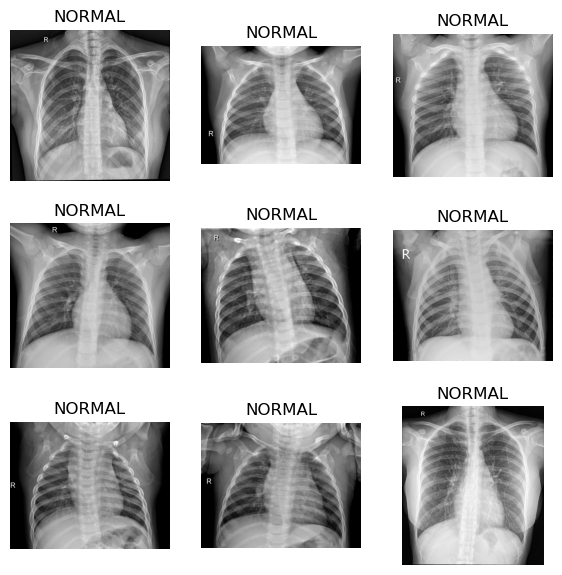

In [7]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join("archive-2/train/normal",Normalimages[i])),cmap='gray')
    plt.axis('off')
    plt.title("NORMAL")
plt.show()

In [8]:
%%time
from pathlib import Path
import pandas as pd
dir = Path('archive-2/train/')

filepaths = list(dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: user 26.5 ms, sys: 6.67 ms, total: 33.2 ms
Wall time: 32.1 ms


,Filepath,Label
0,archive-2/train/opacity/person63_bacteria_306....,opacity
1,archive-2/train/opacity/person755_bacteria_265...,opacity
2,archive-2/train/opacity/person478_virus_975.jpeg,opacity
3,archive-2/train/opacity/person661_bacteria_255...,opacity
4,archive-2/train/opacity/person276_bacteria_129...,opacity
...,...,...
4187,archive-2/train/normal/IM-0183-0001.jpeg,normal
4188,archive-2/train/normal/IM-0460-0001.jpeg,normal
4189,archive-2/train/normal/NORMAL2-IM-1011-0001.jpeg,normal
4190,archive-2/train/normal/NORMAL2-IM-0826-0001.jpeg,normal


In [9]:
dataframe.head()


,Filepath,Label
0,archive-2/train/opacity/person63_bacteria_306....,opacity
1,archive-2/train/opacity/person755_bacteria_265...,opacity
2,archive-2/train/opacity/person478_virus_975.jpeg,opacity
3,archive-2/train/opacity/person661_bacteria_255...,opacity
4,archive-2/train/opacity/person276_bacteria_129...,opacity


In [10]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(
 dataframe, test_size=0.20, random_state=0, stratify=dataframe['Label'])
train['Label'].value_counts()

Label
opacity    2488
normal      865
Name: count, dtype: int64

In [11]:
from tensorflow.image import rgb_to_grayscale 

def pre_process(image):
    image = image = rgb_to_grayscale(image)
    return image

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
#     preprocessing_function=pre_process,
    rescale = 1./255,
    zoom_range = 0.2,
    rotation_range=15,
    horizontal_flip = True
)

test_generator = ImageDataGenerator(
#     preprocessing_function=pre_process,
    rescale=1./255
)

In [13]:
size=224
color_mode='rgb'
batch_size=30
training_set = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)



testing_set = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3353 validated image filenames belonging to 2 classes.
Found 839 validated image filenames belonging to 2 classes.


In [14]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)

train batch  (30, 224, 224, 3)
test batch  (30, 224, 224, 3)


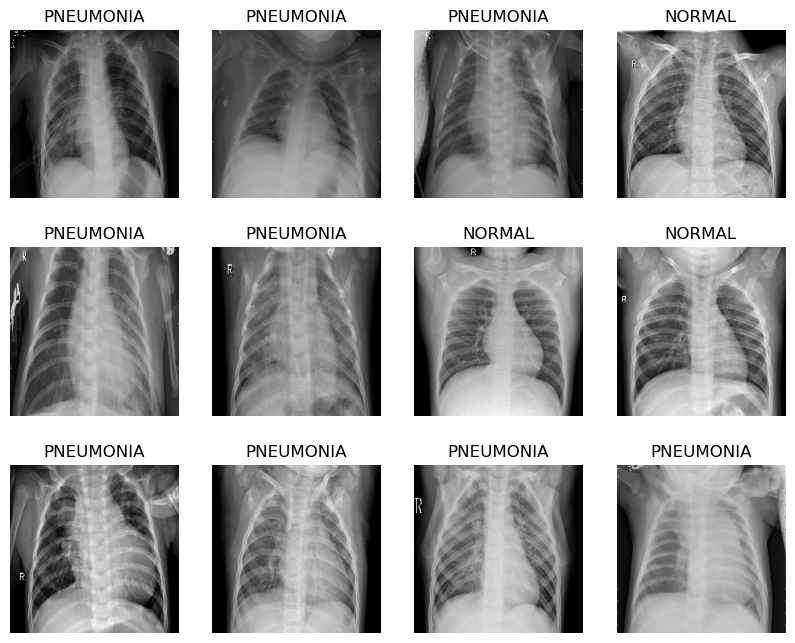

In [ ]:
labels = [ 'NORMAL', 'PNEUMONIA']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [18]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [22]:
print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)

(None, 224, 224, 3)


In [20]:
image_size=224
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
print(pretrained_densenet.input)
for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
print(x1)
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(2, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1920), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [21]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10) 

/var/folders/02/43wzy2052jlg110p42wvwmg80000gn/T/ipykernel_5427/2482404095.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10)


Epoch 1/10
112/112 [==============================] - 380s 3s/step - loss: 0.4047 - accuracy: 0.8798 - val_loss: 0.3095 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 2/10
112/112 [==============================] - 384s 3s/step - loss: 0.3250 - accuracy: 0.9317 - val_loss: 0.3152 - val_accuracy: 0.9273 - lr: 1.0000e-04
Epoch 3/10
112/112 [==============================] - 434s 4s/step - loss: 0.3112 - accuracy: 0.9404 - val_loss: 0.2980 - val_accuracy: 0.9440 - lr: 1.0000e-04
Epoch 4/10
112/112 [==============================] - 364s 3s/step - loss: 0.3019 - accuracy: 0.9532 - val_loss: 0.2827 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 5/10
112/112 [==============================] - 362s 3s/step - loss: 0.2930 - accuracy: 0.9559 - val_loss: 0.2861 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 6/10
112/112 [==============================] - 358s 3s/step - loss: 0.2914 - accuracy: 0.9568 - val_loss: 0.2848 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 7/10
112/112 [====================

In [23]:
model_densenet.save('dens201.hdf5') 


/Users/timworld/anaconda3/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
i=0

In [41]:
import pickle
with open("m.pickle", "wb") as file:
    pickle.dump(model_densenet, file)

In [42]:
import joblib

In [44]:
import pickle
# Import our model
#with open('m.pickle', "rb") as file:
 #   model_densenet = pickle.load(file)
# Ask the user to enter an area and calculate 
# its price using the imported model
# input_area = int(input("Enter area: "))
# img = cv2.imread("/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/normal/00000006_000.png")
# img = cv2.resize(img, (224, 224))
# # img = np.reshape(img, [1, 28, 28, 1])
# # print(np.argmax(model.predict(img)))
# proped_price = model_densenet.predict(img)
# print ("Proped price:", proped_price)
img = cv2.imread("archive-2/test/opacity/person41_virus_88.jpeg")
img = cv2.resize(img, (224, 224))

# Normalize the image
img = img / 255.0  # Normalize pixel values between 0 and 1

# Add a batch dimension to the image
img = np.expand_dims(img, axis=0)

# Predict the label/class using the model
predicted_class = model_densenet.predict(img)
predicted_class = np.argmax(predicted_class, axis=1)
if i==1:
    print("Not  a X ray of chest disease")
else:
    print("Predicted class:", predicted_class)
    if predicted_class==0:
        print("Normal")
    elif predicted_class==1:
        print("pneumonia")
    else:
        print("-----")

1/1 [==============================] - 0s 97ms/step
Predicted class: [1]
pneumonia


In [32]:
import os
print(os.getcwd())


/Users/timworld/Desktop/program/AI
